In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0    418      0 --:--:-- --:--:-- --:--:--   417
Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.basics import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(base_dir + 'l5-sgd-minst')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid),_)=pickle.load(f, encoding='latin-1')

(50000, 784)

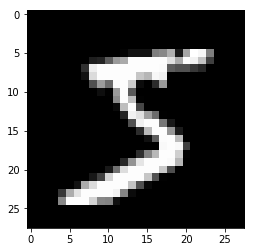

In [0]:
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
x_train.shape

In [0]:
x_train,y_train,x_valid,y_valid =  map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()
                                       

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [0]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnst_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10, bias=True)
    
  def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnst_Logistic().cuda()

In [0]:
model

Mnst_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
  wd = 1e-5
  y_hat = model(x)
  w2 = 0.
  for p in model.parameters(): w2 += (p**2).sum()
  loss = loss_func(y_hat, y) + w2*wd
  loss.backward()
  with torch.no_grad():
      for p in model.parameters():
          p.sub_(lr * p.grad)
          p.grad.zero_()
  return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

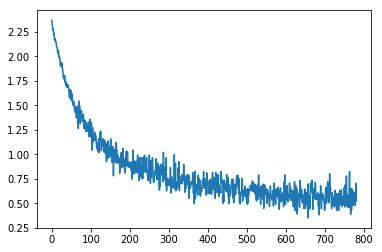

In [0]:
plt.plot(losses)

In [0]:
class Mnist_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = nn.Linear(784, 50, bias=True)
    self.lin2 = nn.Linear(50, 10, bias=True)
    
  def forward(self, xb):
    x = self.lin1(xb)
    x = F.relu(x)
    return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

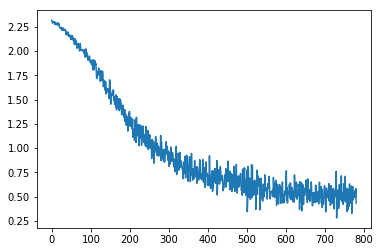

In [0]:
plt.plot(losses)

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
  opt = optim.Adam(model.parameters(),lr)
  y_hat = model(x)
  loss = loss_func(y_hat, y)
  loss.backward()
  opt.step()
  opt.zero_grad()
  return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

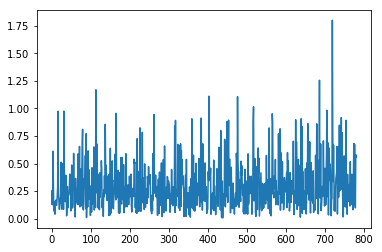

In [0]:
plt.plot(losses)

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


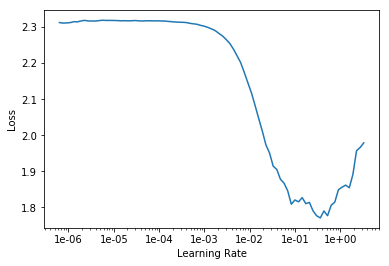

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.155074,0.135189,0.961300,00:03


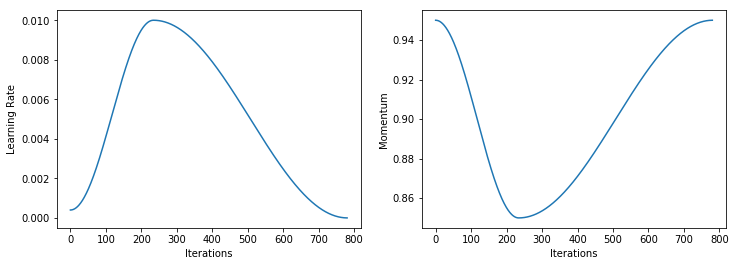

In [0]:
learn.recorder.plot_lr(show_moms=True)

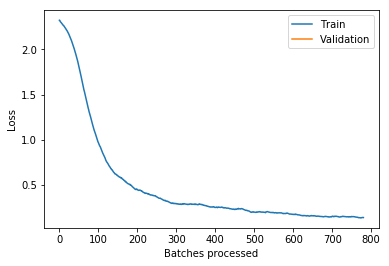

In [0]:
learn.recorder.plot_losses()